In [1]:
import beamtime_config_2018
import ROI_Finder_2018
import XRF_dataset_2018

from beamtime_config_2018 import *
from ROI_Finder_2018 import *
from XRF_dataset_2018 import *

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

## load 2018 XRF data with baseline settings, annotations and artifacts removed

In [2]:
XRF_data = load_XRF_dataset_2018(noise_type = 'none', base_file_path='/data02/AZC/XRF_Data/' )

#for beamtime enable following path and disable above

XRF_data = load_XRF_dataset_2018(noise_type = 'none', base_file_path='/home/beams/USERBNP/arshad/XRF_Data/' )

X=XRF_data['X']
X_bin=XRF_data['X_bin']
X_Cu=XRF_data['X_Cu']
X_Zn=XRF_data['X_Zn']
X_Ca=XRF_data['X_Ca']
X_K=XRF_data['X_K']
X_P=XRF_data['X_P']
X_S=XRF_data['X_S']
X_Fe=XRF_data['X_Fe']
X_Ni=XRF_data['X_Ni']
X_TFY=XRF_data['X_TFY']
principalDf=XRF_data['principalDf']
X_centers=XRF_data['X_centers']
X_xrf_track_files=XRF_data['X_xrf_track_files']


# get the annotated data so remove if not annotated
secondaryDf=principalDf[principalDf['KO_label'] != 'not_annotated' ]
# remove additional artifacts that do not contain 8 pixels
secondaryDf=secondaryDf[secondaryDf['Pixel_count'] >8]

#keep track of the original indices after removing artifacts

secondaryDf['original index'] = secondaryDf.index.to_numpy()
secondaryDf.reset_index(drop=True, inplace=True)


Total extracted cells, features: (554, 14)
Total extracted cell, cell size: (554, 32, 32)


## Construct the feature array after artifact removal and y variable with 0 and 1

In [3]:
mod_X = np.asarray([
    secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
    secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
    secondaryDf['K'],secondaryDf['P'],secondaryDf['Ni'],secondaryDf['Zn'],secondaryDf['Fe'],
    secondaryDf['Cu'],secondaryDf['BFY']
               ]).T

print('Cells, features', mod_X.shape)

labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[
    (secondaryDf['KO_label'] == 'live')
   ].index.tolist()

print('From heuristics, live cell count: ', len(True_list) )

for idx in True_list:
    labels[idx]=1
    
secondaryDf['y'] = labels

y = secondaryDf['y'].to_numpy().astype(int)

Cells, features (303, 13)
From heuristics, live cell count:  85


# perform PCA

Cells, PCs (303, 2)
singular_values_: [37.20672331 35.70114671]
explained_variance: [4.58390814 4.22043668]
components: [[ 0.41713232  0.23324134  0.41880975  0.41010617  0.20284951  0.40656977
   0.19166731  0.24718833  0.19105171 -0.08109155  0.23525062 -0.08109155
  -0.13685688]
 [ 0.2027807   0.00247106  0.19915106  0.12219008  0.21760991  0.1894361
  -0.39926773 -0.31204489 -0.03192634  0.41289993 -0.24734344  0.41289993
   0.4013536 ]]


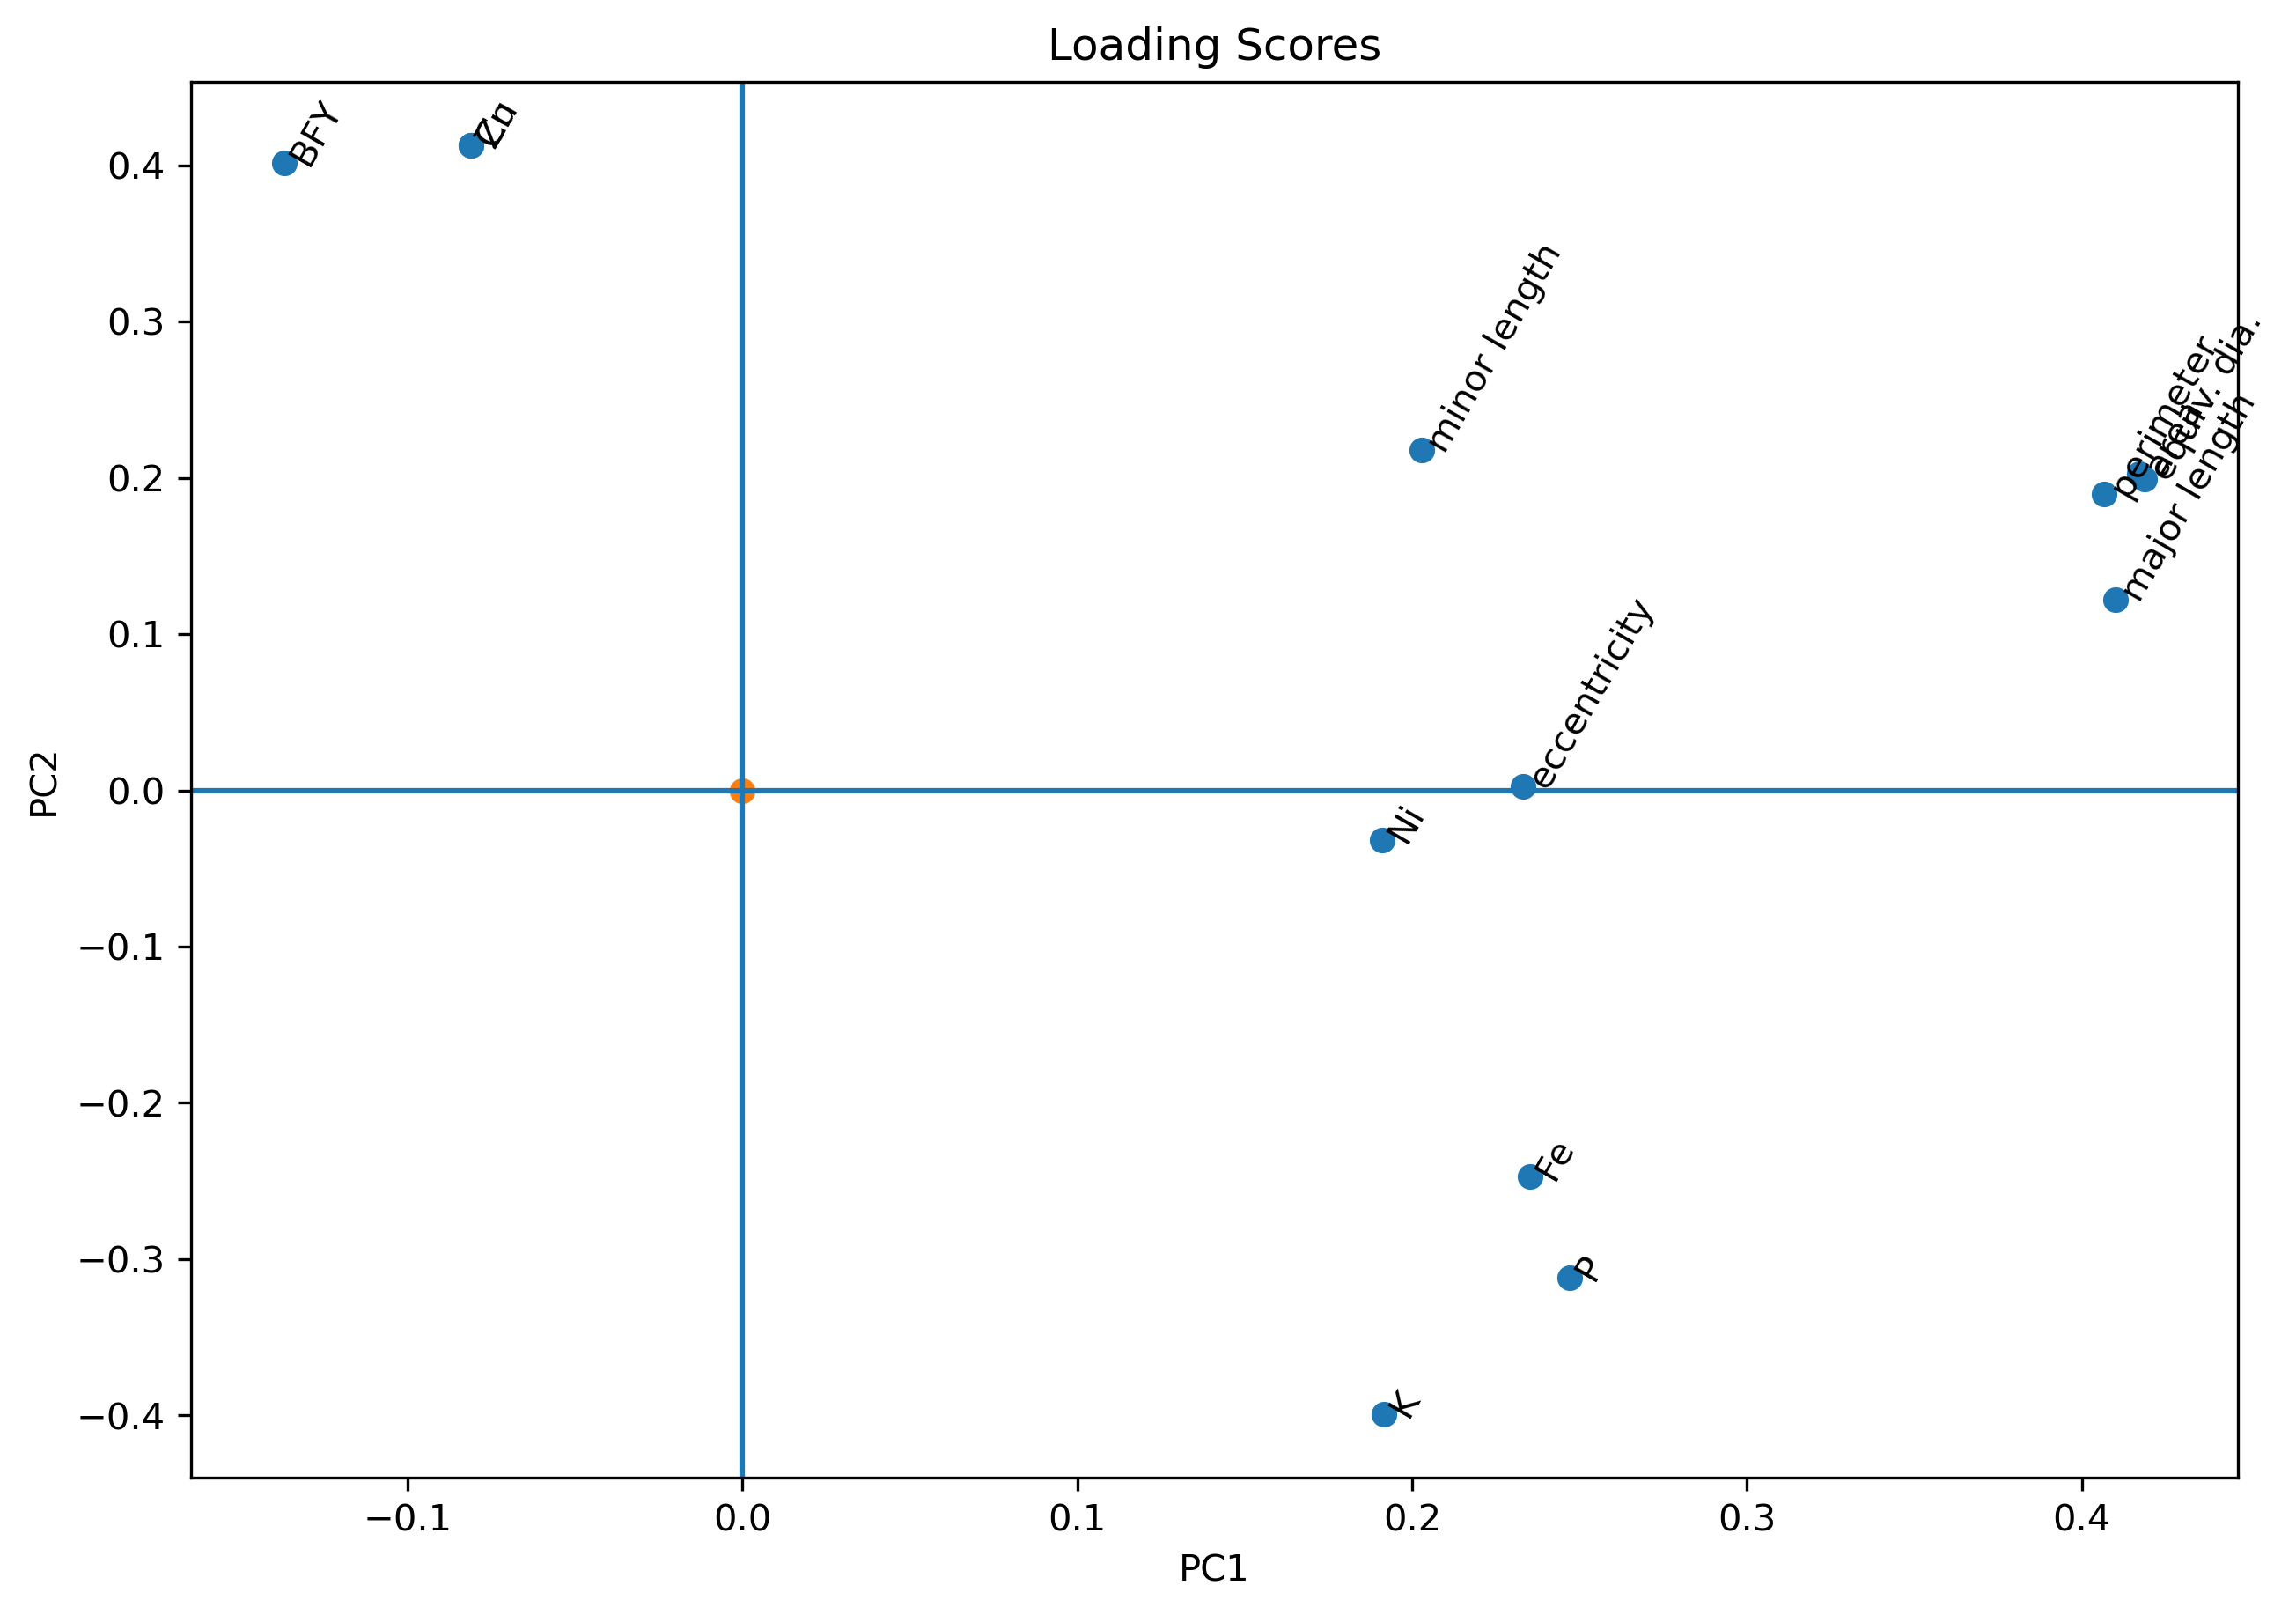

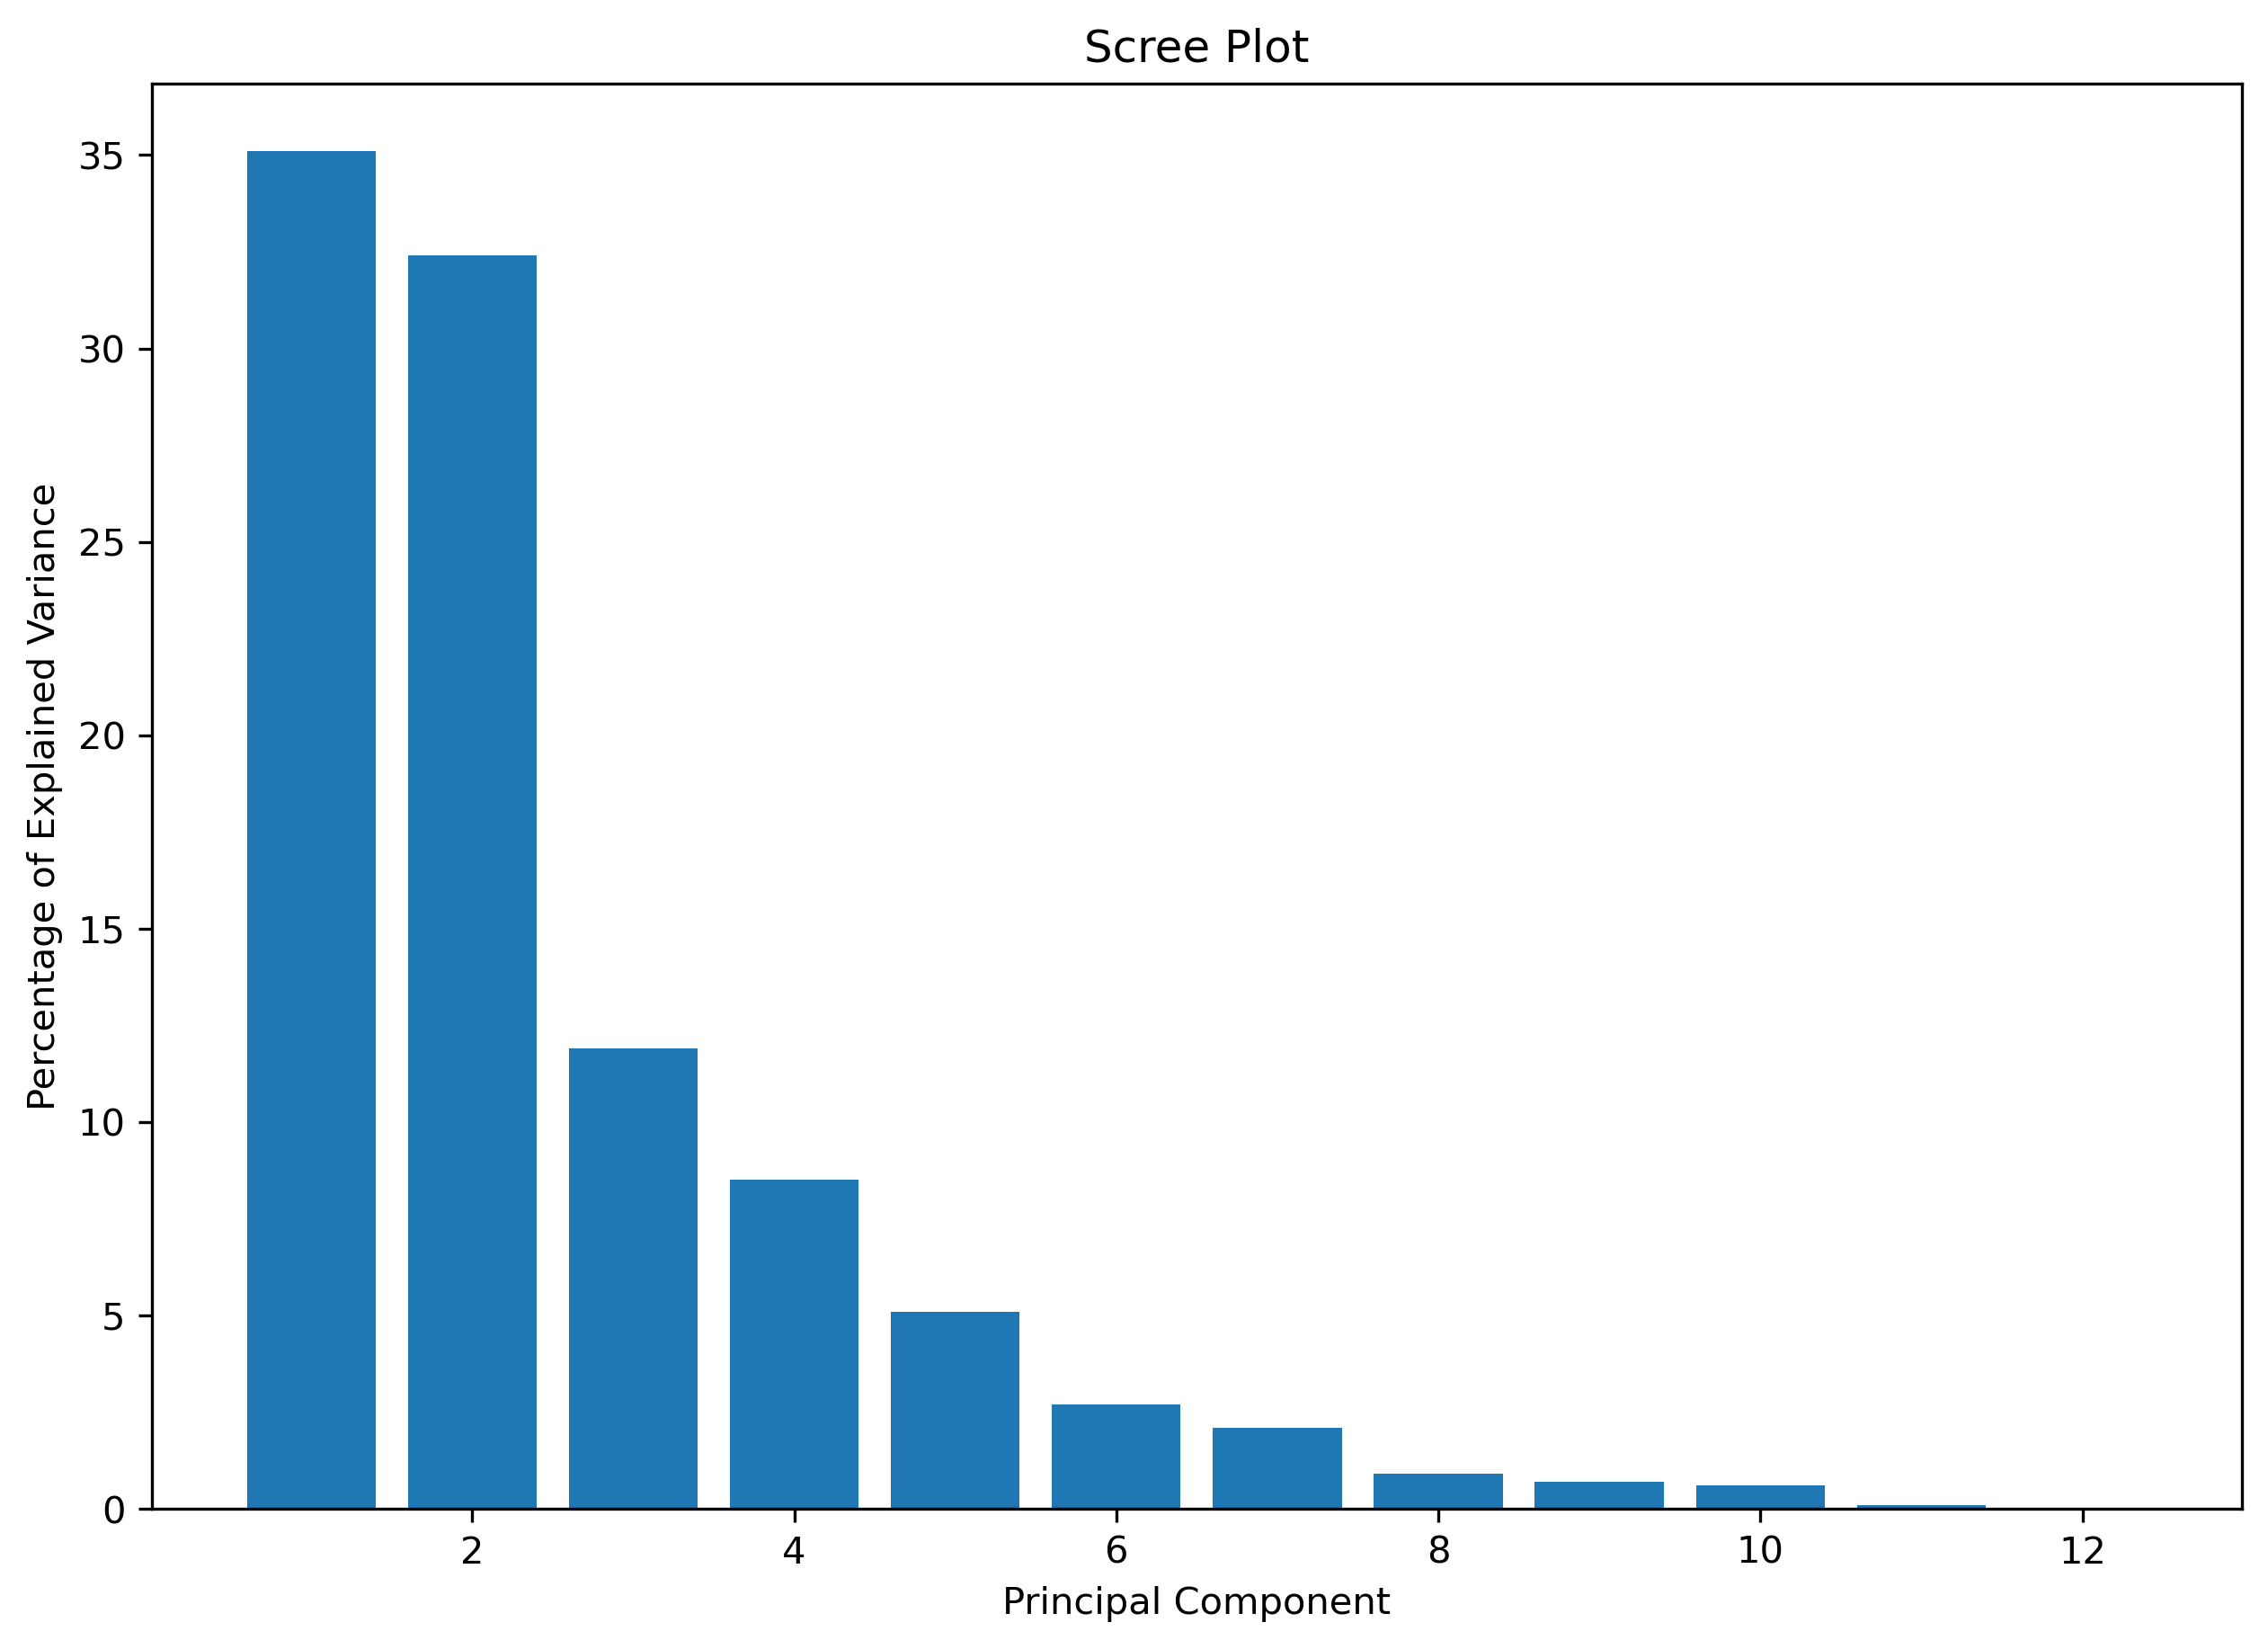

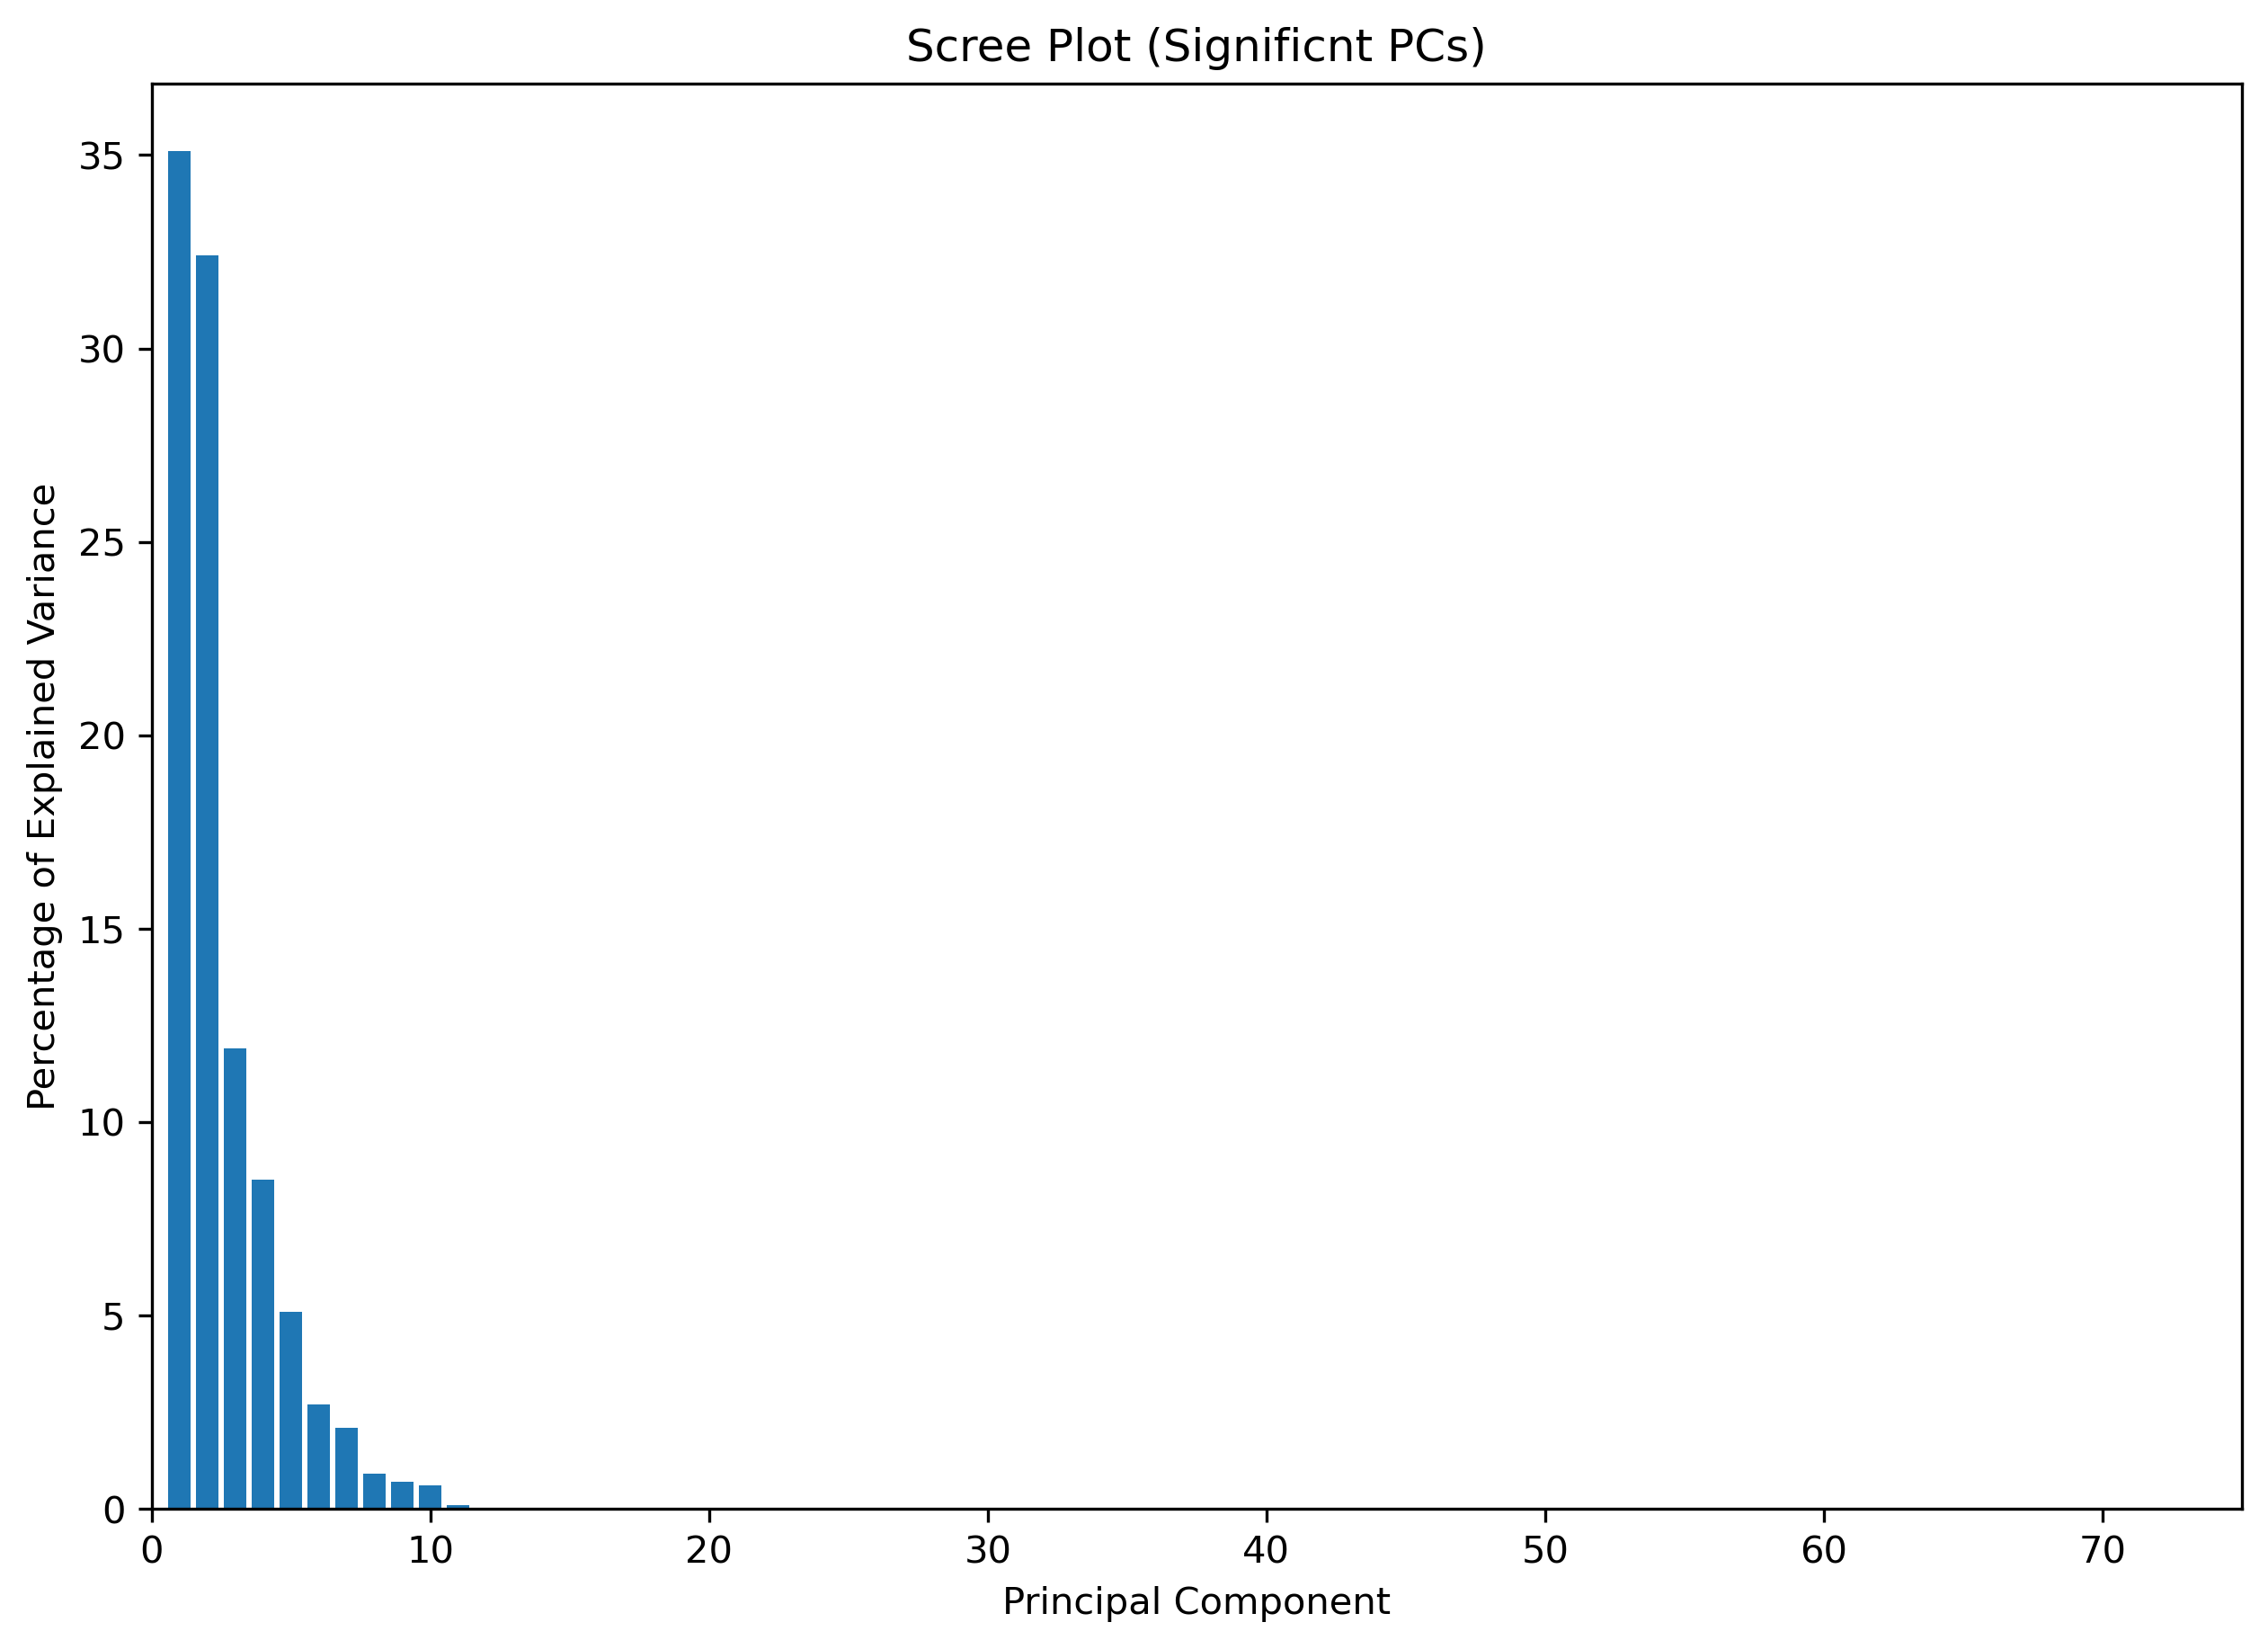

In [4]:
X_standard = StandardScaler().fit_transform(mod_X)
# print(X_standard[0])

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_standard)

secondaryDf['PC1']=principalComponents[:,0]
secondaryDf['PC2']=principalComponents[:,1]

print('Cells, PCs', principalComponents.shape)

print('singular_values_:', pca.singular_values_)
print('explained_variance:', pca.explained_variance_)
print('components:', pca.components_)

fig = plt.figure(figsize=(10,7),dpi=300);

plt.scatter(pca.components_[0],pca.components_[1]) #, tick_label=PClabels
plt.title('Loading Scores')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline()
plt.axvline()

names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ni','Zn',
         'Fe','Cu', 'BFY']

for i, txt in enumerate(names):
    plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]), rotation=60, size=10)

plt.scatter(0,0)
plt.show()

#scree plot

high_pca = PCA(n_components=12)
high_pca.fit_transform(X_standard)

#calculate percentage of variation in each principal components
per_var=np.round(high_pca.explained_variance_ratio_*100, decimals=1)
PClabels =['PC' + str(x) for x in range(1,len(per_var)+1)]

fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()
#zoom in on the important PCs
fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot (Significnt PCs)')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.xlim(0,75)
plt.show()

Text(0, 0.5, 'PC2')

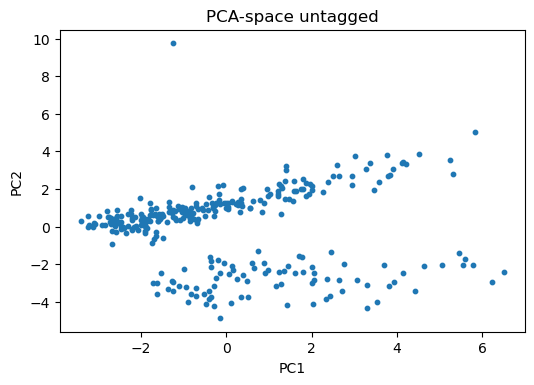

In [5]:
plt.figure(dpi=100)
plt.scatter(secondaryDf['PC1'],secondaryDf['PC2'], s=10)
plt.title('PCA-space untagged')
plt.xlabel('PC1')
plt.ylabel('PC2')

# train MLP using 2018 data, in 2022 data remove copper as feature

In [6]:
# Split data into train partition and test partition
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y, random_state=0, test_size=0.70)

mlp = MLPClassifier(
    hidden_layer_sizes=(15,15),
    max_iter=200,
    alpha=1e-5,
    solver="adam",
    verbose=False,
    random_state=1,
    learning_rate_init=0.002,
)


mlp.fit(X_train, y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

# mlp.predict(X_test)

Training set score: 1.000000
Test set score: 0.995305


In [7]:
X_test.shape

(213, 2)

## preview the PC space used for MLP train test

dict_keys(['dead', 'live'])


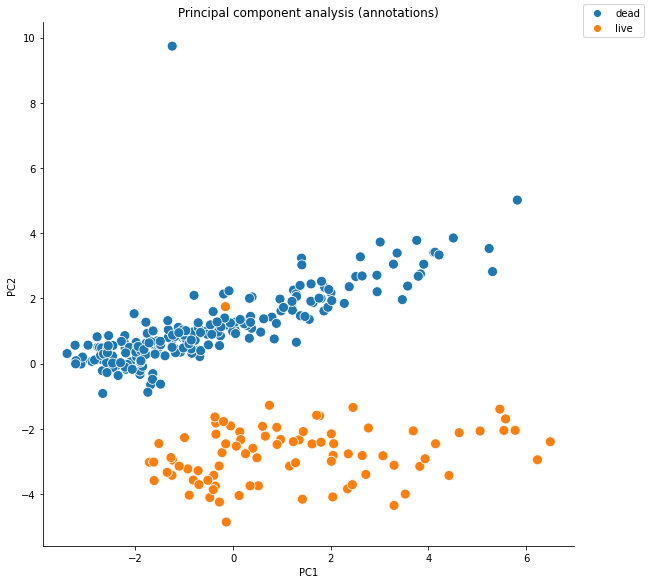

In [8]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='KO_label',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (annotations)')



## select datapoints cluster

<IPython.core.display.Javascript object>


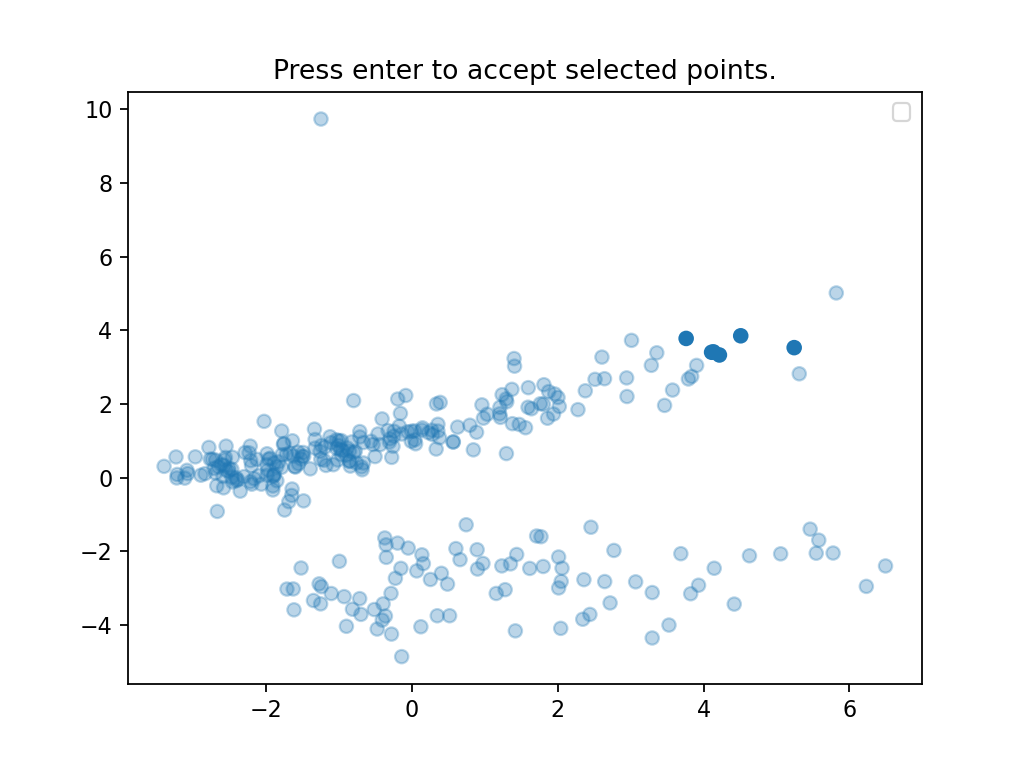

No handles with labels found to put in legend.


In [9]:
%matplotlib notebook


subplot_kw = dict(autoscale_on=True)
fig, ax = plt.subplots(subplot_kw=subplot_kw)

# pts = ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000,c=secondaryDf.Class, facecolors='black')

pts = ax.scatter(secondaryDf['PC1'].to_numpy(),secondaryDf['PC2'].to_numpy(), cmap='winter')

ax.legend()
selector = SelectFromCollection(ax, pts)



fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("Press enter to accept selected points.")

plt.show()



In [11]:
#shows selected indices in secondaryDf
#conversions to original indices
target_scan_cell_indices = secondaryDf['original index'][selector.ind].to_numpy()

pred_y = mlp.predict(principalComponents[selector.ind])


print('modified_indices:', selector.ind)
print('original indices:', target_scan_cell_indices)

pred_list = []
for elm in pred_y:
    if elm == 0:
        pred_list.append('dead')
    elif elm == 1:
        pred_list.append('live')

print('raw class predictions', pred_y)
print('readable predictions', pred_list)


modified_indices: [ 24  33 161 162 193 197]
original indices: [ 46  60 300 305 362 367]
raw class predictions [0 0 0 0 0 0]
readable predictions ['dead', 'dead', 'dead', 'dead', 'dead', 'dead']



# load a single 2022 XRF image, perform PCA, view selector, select via lasso, use 2018 trained MLP to predict.

change copper from mod_X feature list


In [12]:
target_scan_cell_indices

array([ 46,  60, 300, 305, 362, 367])

## add bounding box view on main image for selecting single cell from simple roi finder 2018
or use 2018 viewer or current beamtime viewer depending on type of cell